# Sudoku
Napisz program poszukujący rozwiązania łamigłówki Sudoku za pomocą symulowanego  
wyżarzania. Plansza 9 ×9 ma zostać wczytana z pliku tekstowego, w którym pola puste  
zaznaczone są znakiem x. Jako funkcję kosztu przyjmij sumę powtórzeń cyfr występu-  
jących w wierszach bloku 9 ×9, kolumnach bloku 9 ×9 oraz blokach 3 ×3. Zaproponuj  
metodę generacji stanu sąsiedniego. Przedstaw zależność liczby iteracji algorytmu od  
liczby pustych miejsc na planszy. Czy Twój program jest w stanie znaleźć poprawne  
rozwiązanie dla każdej z testowanych konfiguracji wejściowych?  

In [2]:
import matplotlib.pyplot as plt
import random
import math
from copy import deepcopy

Wczytywanie sudoku z pliku

In [3]:
def read_from_file(filename):
    with open(filename) as file:
        sudoku = file.read()
    sudoku = sudoku.splitlines()
    sudoku = list(map(lambda x : list(x), sudoku))
    return sudoku

Funkcje kosztu 

In [4]:
def find_square(x, y):
    row = x // 3
    col = y // 3

    return [(i + row*3,j + col*3) for i in range(3) for j in range(3)]

def cost(checked_field, sudoku):
    cost = 0
    for field in find_square(*checked_field):
        if (sudoku[checked_field[0]][checked_field[1]] == sudoku[field[0]][field[1]]) and (field != checked_field):
            cost += 1
    for col_num in range(9):
        if (sudoku[checked_field[0]][checked_field[1]] == sudoku[checked_field[0]][col_num]) and (col_num != checked_field[1]):
            cost += 1
    return cost

def cost_all(sudoku):
    final_cost = 0
    for x in range(len(sudoku)):
        for y in range(len(sudoku[0])):
            final_cost += cost((x,y), sudoku)
    return final_cost

Funkcja prawdopodobieństwa

In [5]:
def acceptance_probability(old_cost, new_cost, T):
    if new_cost < old_cost:
        return 1.0
    else:
        return math.exp(-abs(new_cost - old_cost) / T)

Generowanie przykładowego rozwiązania

In [6]:
def generate_random_solution(sudoku):
    for col_num in range(9):
        col = [i for i in range(1,10)]
        for row_num in range(9):
            if sudoku[row_num][col_num] != 'x':
                tmp = col[row_num]
                index = col.index(int(sudoku[row_num][col_num]))
                col[row_num] = sudoku[row_num][col_num]
                col[index] = tmp
        for row_num in range(9):
            sudoku[row_num][col_num] = int(col[row_num])

Funkcja zmiany elementów

In [7]:
def random_change(sudoku, base_sudoku):
    possible_choices = []
    while(len(possible_choices) < 2):
        col_num = random.randint(0,8)
        possible_choices = [i for i in range(9) if base_sudoku[i][col_num] == 'x']
    i,j = random.sample(possible_choices, 2)
    sudoku[i][col_num], sudoku[j][col_num] = sudoku[j][col_num], sudoku[i][col_num]
    return (i, col_num), (j, col_num)

## Symulowane wyżarzanie

In [8]:
def sim_anneal(base_sudoku, cooling_rate=0.999, T=1000, min_temp=1e-4):
    points = deepcopy(base_sudoku)
    generate_random_solution(points)
    
    candidate = deepcopy(points)
    best_res = deepcopy(points)
    curr_cost = cost_all(points)
    best_cost = curr_cost
    costs = [curr_cost]
    
    count = 0
    iteration = 0
    while T > min_temp and count < 2000:
        point_a, point_b = random_change(candidate, base_sudoku)
        iteration += 1

        T = T * cooling_rate
        new_cost = cost_all(candidate)
        if acceptance_probability(curr_cost, new_cost, T) > random.random():
            if new_cost != curr_cost:
                count = 0
            points[point_a[0]][point_a[1]], points[point_b[0]][point_b[1]] = points[point_b[0]][point_b[1]], points[point_a[0]][point_a[1]]
            curr_cost = cost_all(points)
            if(curr_cost < best_cost):
                best_res = deepcopy(points)
                best_cost = curr_cost
        else:
            count += 1
            candidate[point_a[0]][point_a[1]], candidate[point_b[0]][point_b[1]] = candidate[point_b[0]][point_b[1]], candidate[point_a[0]][point_a[1]]
        costs.append(curr_cost)
    return (best_res, costs, iteration)

Generowanie wykresów

In [9]:
def print_sudoku(sudoku):
    for x in range(len(sudoku)):
        if x % 3 == 0 and x !=0:
            print(" ---------------------")
        for y in range(len(sudoku[0])):
            if y % 3 == 0 and y != 0:
                print(" |", end='')
            print(" " + str(sudoku[x][y]), end='')
        print("\n", end='')

def plot_costs(costs):
    plt.plot(costs)
    plt.show()

## Testy
W plikach testowych znajdują się sudoku o zróżnicowanym stopniu uzupełnienia (od 50 do 60 pustych miejsc)

In [20]:
def test_solution(sudoku):
    mistakes = 0
    for x in range(9):
        mistakes += (9 - len(set(sudoku[x])))
    for x in [0,3,6]:
        for y in [0,3,6]:
            mistakes += 9 - len(set([sudoku[i[0]][i[1]] for i in find_square(x,y)]))
    return mistakes

def sudoku_check(sudoku):
    #edge cases
    if not sudoku:
        return False
    
    #rows by rows checking 
    hset = set()
    for i in range(9):
        for j in range(9):
            if sudoku[i][j] in hset:
                return False
            else:
                hset.add(sudoku[i][j])
        hset = set()
            
    #cols by cols checking
    hset = set()
    for i in range(9):
        for j in range(9):
            if sudoku[j][i] in hset:
                return False
            else:
                hset.add(sudoku[j][i])
        hset = set()
    
    
    #3 by 3 check
    subs = [range(0,3), range(3,6), range(6,9)]
    subsudokus = [] 
    for x in subs:
        for y in subs:
            subsudokus.append([x,y])
    for (row_range, column_range) in subsudokus:
        hset = set()
        for i in row_range:
            for j in column_range:              
                if sudoku[i][j] in hset:
                    return False
                else:
                    hset.add(sudoku[i][j])
    
    return True

Przykładowy test

Initial sudoku: 
 x 9 6 | x 4 x | x x 1
 1 x x | x 6 x | x x 4
 5 x 4 | 8 1 x | 3 9 x
 ---------------------
 x x 7 | 9 5 x | x 4 3
 x 3 x | x 8 x | x x x
 4 x 5 | x 2 3 | x 1 8
 ---------------------
 x 1 x | 6 3 x | x 5 9
 x 5 9 | x 7 x | 8 3 x
 x x 3 | 5 9 x | x x 7
Plot of costs: 


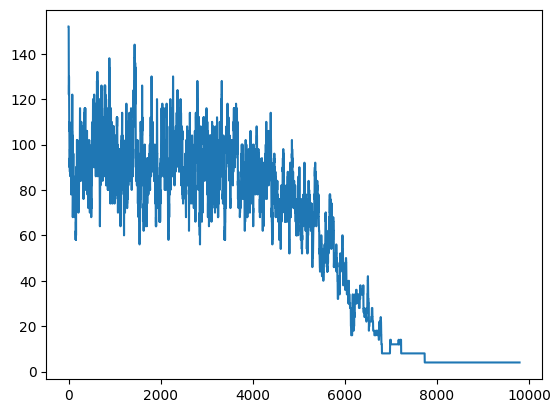

Final sudoku: 
 3 9 6 | 2 4 5 | 2 8 1
 1 2 8 | 3 6 9 | 5 7 4
 5 7 4 | 8 1 7 | 3 9 6
 ---------------------
 2 8 7 | 9 5 1 | 6 4 3
 9 3 1 | 4 8 6 | 7 2 5
 4 6 5 | 7 2 3 | 9 1 8
 ---------------------
 7 1 2 | 6 3 8 | 4 5 9
 6 5 9 | 1 7 4 | 8 3 2
 8 4 3 | 5 9 2 | 1 6 7
Is the solution correct: 
False
How many mistakes: 
2


In [21]:
sudoku = read_from_file("sudoku/0")
print("Initial sudoku: ")
print_sudoku(sudoku)
solution, costs, iterations = sim_anneal(sudoku)
print("Plot of costs: ")
plot_costs(costs)
print("Final sudoku: ")
print_sudoku(solution)
print("Is the solution correct: ")
print(sudoku_check(solution))
print("How many mistakes: ")
print(test_solution(solution))

Testy wielu przykładów

In [22]:
how_many = 40
iterations = []
mistakes = []

for sudoku_num in range(how_many):
    sudoku = read_from_file("sudoku/" + str(sudoku_num))
    solution, costs, iteration = sim_anneal(sudoku)
    iterations.append(iteration)
    mistakes.append(test_solution(solution))

print("Iterations: ")
print(iterations)
print("Average number of iterations: ")
print(sum(iterations)/how_many)
print("Mistakes: ")
print(mistakes)
print("Average number of mistakes: ")
print(sum(mistakes)/how_many)

Iterations: 
[9547, 9106, 9066, 9792, 9150, 9514, 9240, 9432, 9161, 9287, 9105, 10054, 9321, 10248, 9461, 8996, 9461, 9870, 9152, 9013, 9878, 11370, 10975, 10903, 9572, 10378, 10183, 10232, 9543, 9763, 9428, 10028, 11395, 9871, 9986, 9670, 9765, 9850, 10157, 9821]
Average number of iterations: 
9768.6
Mistakes: 
[2, 0, 0, 0, 0, 4, 4, 0, 2, 0, 0, 4, 0, 0, 3, 0, 0, 4, 4, 0, 4, 2, 6, 6, 4, 0, 8, 4, 4, 7, 11, 2, 5, 4, 2, 5, 7, 2, 4, 5]
Average number of mistakes: 
2.975


## Podsumowanie
Rozwiązywanie sudoku przy pomocy wyżarzania daje lepsze wyniki, gdy liczba pól do uzupełnienia jest mała.  
Wraz z jej wzrostem liczba błędów popełnianych przez algorytm rośnie.